# **Case Técnico – Cientista de Dados Júnior | Datarisk (Modelagem)**

Nesta etapa, será desenvolvido um modelo preditivo para estimar a probabilidade de inadimplência associada às cobranças mensais dos clientes. Esse tipo de solução é conhecido como modelo de PD (Probability of Default).

O objetivo é identificar, com antecedência, quais clientes apresentam maior propensão a atrasar o pagamento em 5 dias ou mais, conforme definido no problema. Para isso, serão avaliadas diferentes abordagens de modelagem, buscando um equilíbrio entre desempenho preditivo, interpretabilidade e robustez temporal.

Dentre os algoritmos considerados, utilizarei:

- **Regressão Logística:** modelo clássico em risco de crédito, interpretável e adequado como baseline para avaliação inicial de performance.

- **XGBoost (Extreme Gradient Boosting):** método ensemble baseado em árvores de decisão, capaz de capturar relações não lineares e interações complexas entre variáveis, frequentemente apresentando ganhos de performance em comparação a modelos lineares.


### **Importando as bibliotecas**

#### **Manipulação e Estruturação de Dados**

* **pandas (pd)** – Leitura, tratamento e manipulação de DataFrames.
* **numpy (np)** – Operações numéricas vetorizadas e funções matemáticas.

#### **Visualização**

* **matplotlib / pyplot (mpl, plt)** – Criação de gráficos básicos e customização de estilo.
* **seaborn (sns)** – Visualizações estatísticas de alto nível, com paletas personalizadas.

#### **Modelagem e Machine Learning (scikit-learn)**

* **Pipeline** – Encadeamento de pré-processamento + modelo de forma reprodutível.
* **LogisticRegression** – Modelo base para previsão de inadimplência (PD model).
* **SimpleImputer** – Tratamento de valores faltantes.
* **StandardScaler** – Padronização de variáveis numéricas.
* **OneHotEncoder** – Transformação de variáveis categóricas.
* **ColumnTransformer** – Aplicação de diferentes transformações por tipo de coluna.

#### **Métricas de Avaliação**

* **roc_auc_score, roc_curve** – Métricas centrais para modelos de risco.
* **brier_score_loss** – Avaliação de calibração.
* **confusion_matrix** – Relação entre previsões positivas/negativas.

#### **Modelo**
* **joblib**: Salvar pipeline e modelo treinado

#### **Configurações e Estilo**

* Definição de estilos visuais (ggplot, cores, grid).
* Paletas personalizadas para padronização dos gráficos.
* Suppressão de warnings irrelevantes.


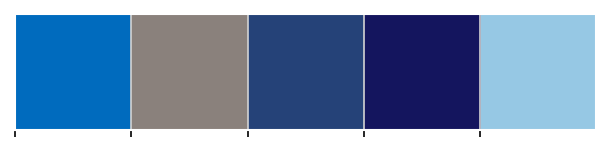

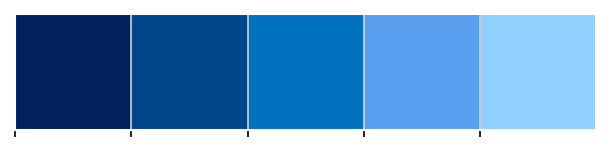

In [56]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

import shap

import joblib

from src.modelling_utils import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

mpl.style.use('ggplot')
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

# Palette
instyle_palette = ['#006bbe', '#8a817c', '#254278', "#14155E", '#96c8e4']
progress_palette = ['#00215d', '#00468b', '#0071bc', '#589fef', '#8fd0ff']


sns.set_palette(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(progress_palette))

### **Carregamento e Preparação Inicial dos Dados**

A função read_and_clean_data é responsável por realizar a leitura dos arquivos brutos a partir dos caminhos fornecidos. Após o carregamento, essa função aplica as correções, padronizações e tratamentos definidos durante a etapa de EDA, garantindo que todos os datasets utilizados na modelagem estejam consistentes, limpos e prontos para integração.

In [57]:
df = read_and_clean_data('../data/processed/base_pagamentos_desenvolvimento.xlsx', file_type='xlsx')

In [58]:
df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN


Para garantir consistência entre as bases e melhorar a capacidade preditiva do modelo, foram extraídos **dia e mês** das variáveis temporais. Essa decomposição facilita a interpretação dos padrões sazonais, reduz a complexidade dos dados de data e permite que o modelo capture melhor efeitos como:

* variações mensais ou sazonais de inadimplência;
* comportamento associado ao dia de vencimento;
* envelhecimento da relação cliente–empresa ao longo do tempo.

Além disso, a transformação torna as features mais explicáveis e adequadas para algoritmos lineares e baseados em árvores, preservando integridade e reprodutibilidade na etapa de modelagem.


In [59]:
df['DIA_VENCIMENTO_DOCUMENTO'] = (df['DATA_VENCIMENTO']).dt.day
df['MES_VENCIMENTO_DOCUMENTO'] = (df['DATA_VENCIMENTO']).dt.month
df['TEMPO_DE_PAGAMENTO'] = (df['DATA_VENCIMENTO'] - df['DATA_EMISSAO_DOCUMENTO']).dt.days
df['DIA_REF'] = (df['SAFRA_REF']).dt.day
df['MES_REF'] = (df['SAFRA_REF']).dt.month
df['ANO_REF'] = (df['SAFRA_REF']).dt.year

df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN,6,9,20,1,8,2018
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,19,1,8,2018
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,19,1,8,2018
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,6,9,16,1,8,2018
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,5,9,16,1,8,2018


Para a variável DATA_CADASTRO, foi criado o tempo de relacionamento do cliente até a data da cobrança, calculado como a diferença em meses entre DATA_CADASTRO e SAFRA_REF.

In [60]:
df['TEMPO_RELACIONAMENTO'] = (
    (df['SAFRA_REF'].dt.year - df['DATA_CADASTRO'].dt.year) * 12 +
    (df['SAFRA_REF'].dt.month - df['DATA_CADASTRO'].dt.month)
)

df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF,TEMPO_RELACIONAMENTO
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN,6,9,20,1,8,2018,60
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,19,1,8,2018,36
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,19,1,8,2018,36
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,6,9,16,1,8,2018,36
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,5,9,16,1,8,2018,36


Após extrair os componentes relevantes das datas (dia e mês) e calcular as métricas temporais necessárias, as colunas originais de data podem ser removidas. Isso evita redundância, reduz dimensionalidade e previne que informações não estruturadas em formato de data impactem negativamente o modelo. Deixarei apenas SAFRA_REF para realizar a separação entre treino e teste, entretanto, ao fazer a separação, ela também será removida.

Removerei também, DOMINIO_EMAIL, uma vez que esta variável não carrega valor preditivo satisfatório para a modelagem e não possui nenhuma informação crucial de crédito.

In [61]:
cols_to_drop = ['DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'DDD', 'CEP_2_DIG', 'DATA_CADASTRO', 'DOMINIO_EMAIL']

df.drop(cols_to_drop, axis=1, inplace=True)

df.head()

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,TARGET,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF,TEMPO_RELACIONAMENTO
0,1661240395903230976,2018-08-01,35516.41,6.99,0,0,Serviços,PEQUENO,9,6,NaN,NaN,6,9,20,1,8,2018,60
1,5726178124659660800,2018-08-01,210851.55,5.99,0,0,Indústria,MEDIO,6,6,NaN,NaN,10,9,19,1,8,2018,36
2,5726178124659660800,2018-08-01,153540.00,5.99,0,0,Indústria,MEDIO,6,6,NaN,NaN,10,9,19,1,8,2018,36
3,5726178124659660800,2018-08-01,75064.00,5.99,0,0,Indústria,MEDIO,6,6,NaN,NaN,6,9,16,1,8,2018,36
4,5726178124659660800,2018-08-01,80550.14,5.99,0,0,Indústria,MEDIO,6,6,NaN,NaN,5,9,16,1,8,2018,36


### **Separação: Treino e Teste**

Para garantir consistência temporal e evitar que o modelo tenha acesso a informações futuras, foi adotado um split Out-of-Time (OOT). Esse tipo de divisão utiliza períodos mais antigos para treino e períodos mais recentes para teste, respeitando a cronologia natural das cobranças. Dessa forma, avaliamos o modelo em um cenário que simula corretamente sua aplicação real, onde previsões são feitas sempre para períodos posteriores aos utilizados no treinamento.

In [62]:
train, test = np.split(df, [int(.80 * len(df))])

train['SET'] = 'train'
test['SET'] = 'test'

In [63]:
print(f"Taxa de inadimplente conjunto de treino:\n {train['TARGET'].value_counts(normalize=True)}.")
print()
print(f"Taxa de inadimplente conjunto de teste:\n {test['TARGET'].value_counts(normalize=True)}.")

Taxa de inadimplente conjunto de treino:
 TARGET
0    0.927968
1    0.072032
Name: proportion, dtype: float64.

Taxa de inadimplente conjunto de teste:
 TARGET
0    0.937028
1    0.062972
Name: proportion, dtype: float64.


In [64]:
print(f'O conjunto de treino tem {train.shape[0]} linhas e {train.shape[1]} colunas')
print(f'O conjunto de teste tem {test.shape[0]} linhas e {test.shape[1]} colunas')

O conjunto de treino tem 61931 linhas e 20 colunas
O conjunto de teste tem 15483 linhas e 20 colunas


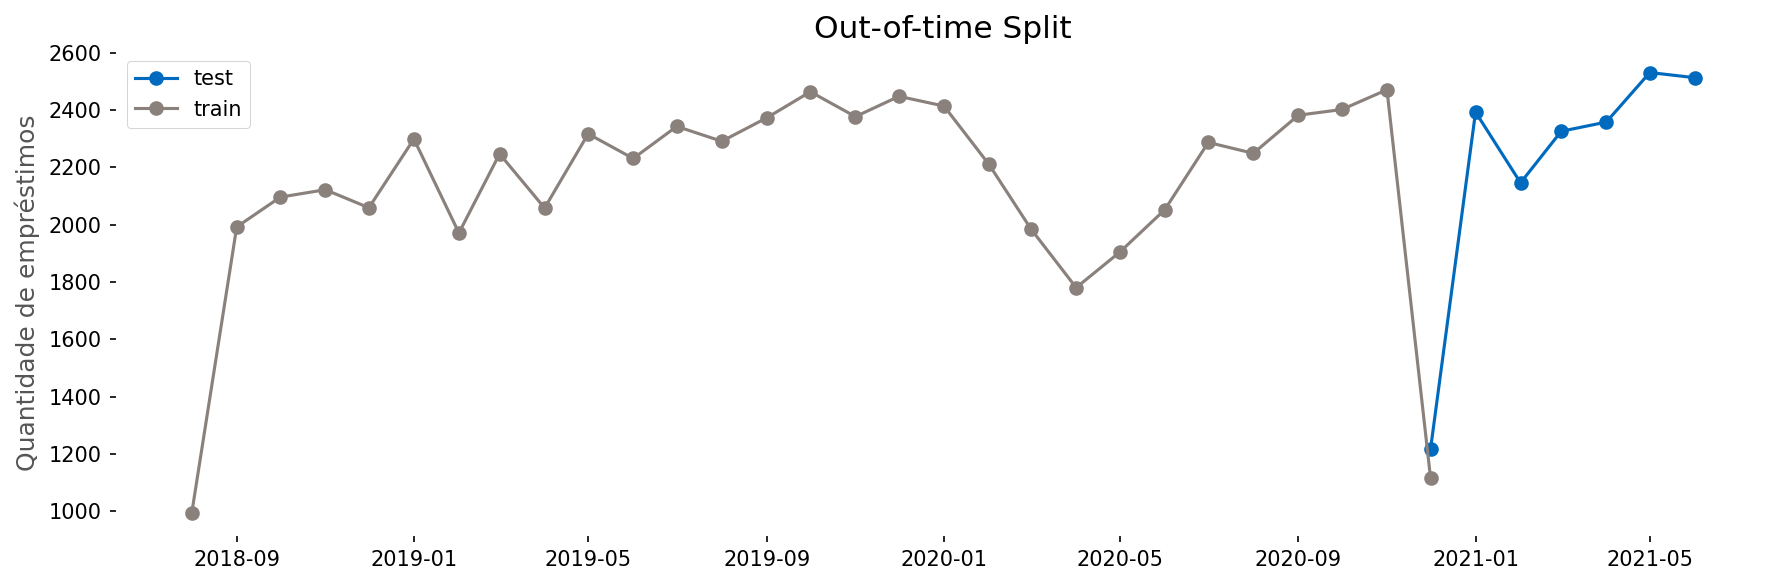

In [65]:
train_test = pd.concat([train, test])
train_test = (
    train_test
    .groupby(['SAFRA_REF', 'SET'])['TARGET']
    .count()
    .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Out-of-time Split', fontsize=15)

for set_name, df_set in train_test.groupby('SET'):
    ax.plot(df_set['SAFRA_REF'], df_set['TARGET'], marker='o', label=set_name)

ax.set_ylabel('Quantidade de empréstimos')
ax.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Observamos o OoT Split no gráfico acima. Em cinza, estão os dados de treinamento e em azul, os dados de teste. O intuito é respeitar a ordem cronólogica das cobranças e garantir que o modelo seja avaliado em um cenário realista, o qual previsões são feitas apenas em períodos futuros em relação aos dados de treinamento. 

In [66]:
missing_df = df.isna().sum().to_frame().rename(columns={0: 'count'}).sort_values(by=['count'], ascending=False)
missing_df['pct'] = round(missing_df['count'] / df.shape[0] * 100, 3)
missing_df.head(10)

,count,pct
NO_FUNCIONARIOS,4135,5.341
RENDA_MES_ANTERIOR,4017,5.189
PORTE,2476,3.198
REGIAO_DDD,1821,2.352
SEGMENTO_INDUSTRIAL,1417,1.830
VALOR_A_PAGAR,27,0.035
REGIAO_CEP,8,0.010
SAFRA_REF,0,0.000
ID_CLIENTE,0,0.000
TAXA,0,0.000


### **Análise de Valores Ausentes**

A tabela acima apresenta a quantidade e o percentual de valores faltantes por variável no dataset. Observamos que:

* **REGIAO_DDD** e **RENDA_MES_ANTERIOR** possuem os maiores percentuais de missing, acima de 5%.
* Variáveis como **REGIAO_DDD**, **PORTE** e **SEGMENTO_INDUSTRIAL** apresentam níveis moderados de ausência.
* A maior parte das variáveis apresenta **pouco ou nenhum missing**, o que reduz a necessidade de tratamentos agressivos.

Com base nesses resultados, aplicaremos estratégias de imputação adequadas ao tipo da variável (numérica ou categórica), garantindo consistência durante o pré-processamento e evitando perda de informação.

### **Modelagem: Baseline**


**Separação entre treino e teste**

In [67]:
X_train = train.drop(['TARGET', 'ID_CLIENTE', 'SAFRA_REF'], axis=1)
y_train = train['TARGET']
X_test = test.drop(['TARGET', 'ID_CLIENTE', 'SAFRA_REF'], axis=1)
y_test = test['TARGET']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((61931, 17), (61931,), (15483, 17), (15483,))

In [68]:
num_cols = [
    'VALOR_A_PAGAR',
    'RENDA_MES_ANTERIOR',
    'NO_FUNCIONARIOS',
    'DIA_VENCIMENTO_DOCUMENTO',
    'MES_VENCIMENTO_DOCUMENTO',
    'DIA_REF',
    'MES_REF',
    'TEMPO_RELACIONAMENTO'
]

cat_cols = [
    'FLAG_PF',
    'TAXA',
    'SEGMENTO_INDUSTRIAL',
    'PORTE',
    'REGIAO_DDD',
    'REGIAO_CEP'
]

## **Pré-processamento das variáveis**

Antes da etapa de modelagem, é fundamental garantir que todas as variáveis estejam estruturadas de forma adequada para os algoritmos utilizados. Para isso, definimos três fluxos de tratamento distintos: **variáveis numéricas**, **variáveis categóricas**.

Esse processo assegura consistência, evita problemas de escala, trata valores ausentes e organiza a informação de modo a maximizar o poder preditivo do modelo.


### **1. Variáveis Numéricas**

As variáveis numéricas passam por duas etapas principais: **imputação** e **padronização**.

1. **Imputação por mediana**
   Valores ausentes são substituídos pela mediana da variável. Essa estratégia é robusta a outliers e evita que valores extremos distorçam a imputação.

2. **Padronização (StandardScaler)**
   Após a imputação, cada variável é transformada para uma escala comum, com média zero e desvio-padrão igual a um:

$$[
z = \frac{x - \mu}{\sigma}
]$$

Essa padronização é importante especialmente para modelos lineares, garantindo que a magnitude das variáveis não influencie de forma desigual o processo de otimização.

Esse pipeline assegura que todas as variáveis numéricas sejam interpretadas em uma mesma escala e sem valores faltantes.


### **2. Variáveis Categóricas**

As variáveis categóricas são tratadas por meio de **imputação** e **codificação**.

1. **Imputação por categoria mais frequente (moda)**
   Valores ausentes são substituídos pela categoria mais comum da variável. Isso preserva a distribuição original e evita introduzir categorias artificiais.

2. **Codificação via One-Hot Encoding**
   Cada categoria é convertida em uma coluna binária, permitindo que o modelo utilize corretamente essas variáveis. 

Esse procedimento garante que toda variável categórica possa ser utilizada em modelos lineares e de árvore sem perda de informação.




In [69]:
num_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preproc, num_cols),
        ('cat', cat_preproc, cat_cols),
    ]
)

### **Pipeline de Modelagem**

Para a etapa de modelagem, adotamos dois algoritmos complementares: **Regressão Logística**, como modelo base interpretável, e **XGBoost**, como método de aprendizado de máquina mais robusto e capaz de capturar relações não lineares entre variáveis. Essa combinação permite avaliar desempenho, interpretabilidade e estabilidade temporal no contexto de previsão de inadimplência.

#### **1. Regressão Logística**

A Regressão Logística é um modelo estatístico utilizado em risco de crédito por sua simplicidade e capacidade de estimar probabilidades. A probabilidade de inadimplência é modelada por meio da função logística:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k)}}
$$

onde:

- $Y = 1$ indica inadimplência,  
- $X = (x_1, x_2, \dots, x_k)$ representa o vetor de variáveis explicativas,  
- $\beta = (\beta_0, \beta_1, \dots, \beta_k)$ são os coeficientes estimados.

A função logística transforma a combinação linear das variáveis em uma probabilidade entre 0 e 1.  

#### **2. XGBoost (Extreme Gradient Boosting)**

O XGBoost é um algoritmo baseado em **árvores de decisão**, construído sob o paradigma de **boosting gradiente**. O método treina diversas árvores sequencialmente, onde cada árvore tenta corrigir os erros da anterior, permitindo capturar interações complexas entre as variáveis.

O objetivo do modelo pode ser escrito como:

$$
\mathcal{L}(\phi) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{t=1}^{T} \Omega(f_t)
$$

onde:

- $l(y_i, \hat{y}_i)$ é a função de perda (por exemplo, perda logística),  
- $f_t$ é a árvore adicionada na iteração $t$,  
- $\Omega(f_t)$ é um termo de regularização que controla a complexidade do modelo (profundidade, número de folhas etc.).

A atualização de cada árvore é feita aproximando o gradiente da função de perda com respeito às previsões anteriores:

$$
g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}
$$




In [70]:
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=500,
    class_weight=None,
    fit_intercept=True,
    random_state=42
)

baseline_log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', logreg)
])

baseline_log_reg.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
y_preds_log_reg = baseline_log_reg.predict(X_test)
y_probas_log_reg = baseline_log_reg.predict_proba(X_test)[:, 1]

### **Métricas de Discriminação e Calibração**

Para avaliar a qualidade de um modelo de inadimplência, utilizamos métricas que medem quão bem ele separa bons e maus pagadores (**discriminação**) e quão bem as probabilidades previstas refletem a realidade (**calibração**). Aqui destacamos quatro métricas centrais: **AUC**, **KS**, **Gini** e **Brier Score**.


#### **1. AUC – Area Under the ROC Curve**

A AUC mede a capacidade do modelo de **ranquear corretamente** clientes inadimplentes acima dos adimplentes, considerando todos os possíveis pontos de corte.

Intuitivamente, a AUC é a probabilidade de que, escolhendo um cliente inadimplente e um adimplente ao acaso, o modelo atribua um score maior ao inadimplente.


#### **2. KS – Kolmogorov–Smirnov Statistic**

O KS mede a **máxima separação** entre as distribuições acumuladas de score para adimplentes e inadimplentes.

Sejam:
- $F_1(s)$: função distribuição acumulada (CDF) dos scores para inadimplentes  
- $F_0(s)$: CDF dos scores para adimplentes  

O KS é definido como:

$$
KS = \max_s \left| F_1(s) - F_0(s) \right|
$$

Quanto maior o KS, melhor o modelo consegue separar as duas populações.  


#### **3. Gini Coefficient**

O coeficiente de Gini é uma transformação linear da AUC:

$$
Gini = 2 \cdot AUC - 1
$$

Assim, um modelo com AUC = 0{,}75 terá:

$$
Gini = 2 \cdot 0{,}75 - 1 = 0{,}5
$$

Indica a qualidade do modelo

#### **4. Brier Score**

O Brier Score avalia a **calibração** das probabilidades previstas. Ele mede o erro quadrático médio entre as probabilidades estimadas $\hat{p}_i$ e os resultados reais $y_i \in \{0,1\}$:

$$
BS = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{p}_i \right)^2
$$

- Quanto **menor** o Brier, melhor a calibração.  
- Um modelo bem calibrado atribui, por exemplo, cerca de 10% de inadimplência para grupos onde de fato ~10% se tornam inadimplentes.

Enquanto AUC, KS e Gini focam em quão bem o modelo ordena os clientes por risco, o Brier Score responde o quão confiáveis são as probabilidades numéricas produzidas pelo modelo.


In [72]:
metrics_test = evaluate_global_metrics(y_test, y_probas_log_reg)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.726061
KS,0.360301
Gini,0.452123
Brier,0.055746


O modelo baseline apresenta desempenho sólido, com poder discriminativo adequado (AUC ≈ 0.75, KS ≈ 0.40, Gini ≈ 0.50) e excelente calibração (Brier ≈ 0.055). Esses resultados indicam que o modelo separa bem clientes de diferentes níveis de risco e fornece probabilidades consistentes com o comportamento observado nos dados. 

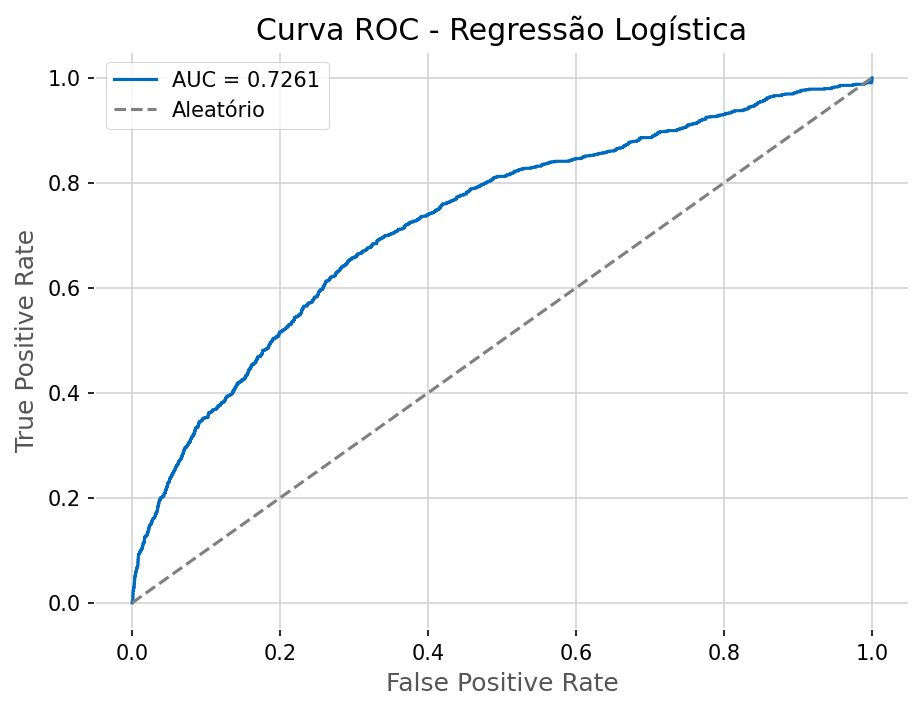

In [73]:
plot_roc_curve(y_test, y_probas_log_reg, title='Curva ROC - Regressão Logística')

In [74]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    n_jobs=-1,
    random_state=42
)

baseline_xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', xgb)
])

baseline_xgb.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [75]:
y_preds_xgb = baseline_xgb.predict(X_test)
y_probas_xgb = baseline_xgb.predict_proba(X_test)[:, 1]

In [76]:
metrics_test = evaluate_global_metrics(y_test, y_probas)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.822406
KS,0.539967
Gini,0.644812
Brier,0.047310


O modelo XGBoost superou amplamente o baseline linear, apresentando excelente capacidade discriminativa (AUC ≈ 0.82, KS ≈ 0.54, Gini ≈ 0.65) e notável calibração (Brier ≈ 0.048). O modelo demonstra maturidade estatística, estabilidade operacional e clareza na separação dos perfis de risco.

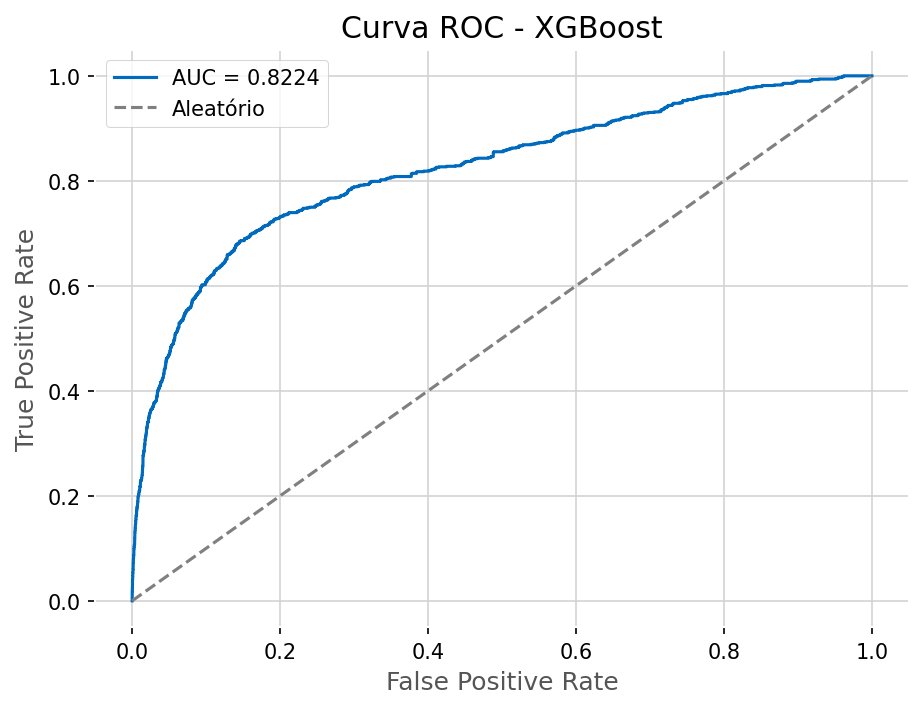

In [77]:
plot_roc_curve(y_test, y_probas_xgb, title='Curva ROC - XGBoost')

### **Conclusão sobre os modelos baseline**

- A partir da avaliação das métricas de cada modelo acima, pode-se chegar nas seguintes conclusões:
    - O modelo de Regressão Logística apresentou métricas satisfatórias, com ROC-AUC em torno de pouco mais de 0,72. Um excelente coeficiente para um base modelo como a Reg. Log., que é computacionalmente mais barato e um modelo mais interpretável.
    - O modelo de boosting (XGBoost) apresentou um desempenho significativamente maior, cerca de mais de 0,82 de coeficiente AUC. Isso denota a força e a performance do algoritmo, que é conhecido por lidar melhor com problemas de multicolinearidade.

- A Regressão Logística apresenta custo computacional substancialmente menor do que métodos baseados em árvores, como o XGBoost. Por operar com otimização convexa e prever por meio de uma simples combinação linear de variáveis.

### **Feature Importance**

In [78]:
feature_names = baseline_log_reg.named_steps['preprocess'].get_feature_names_out()

feature_names

array(['num__VALOR_A_PAGAR', 'num__RENDA_MES_ANTERIOR',
       'num__NO_FUNCIONARIOS', 'num__DIA_VENCIMENTO_DOCUMENTO',
       'num__MES_VENCIMENTO_DOCUMENTO', 'num__DIA_REF', 'num__MES_REF',
       'num__TEMPO_RELACIONAMENTO', 'cat__FLAG_PF_0', 'cat__FLAG_PF_1',
       'cat__TAXA_4.99', 'cat__TAXA_5.99', 'cat__TAXA_6.99',
       'cat__TAXA_8.99', 'cat__TAXA_11.99',
       'cat__SEGMENTO_INDUSTRIAL_Comércio',
       'cat__SEGMENTO_INDUSTRIAL_Indústria',
       'cat__SEGMENTO_INDUSTRIAL_Serviços', 'cat__PORTE_GRANDE',
       'cat__PORTE_MEDIO', 'cat__PORTE_PEQUENO', 'cat__REGIAO_DDD_0',
       'cat__REGIAO_DDD_1', 'cat__REGIAO_DDD_2', 'cat__REGIAO_DDD_3',
       'cat__REGIAO_DDD_4', 'cat__REGIAO_DDD_5', 'cat__REGIAO_DDD_6',
       'cat__REGIAO_DDD_7', 'cat__REGIAO_DDD_8', 'cat__REGIAO_DDD_9',
       'cat__REGIAO_DDD_n', 'cat__REGIAO_CEP_1', 'cat__REGIAO_CEP_2',
       'cat__REGIAO_CEP_3', 'cat__REGIAO_CEP_4', 'cat__REGIAO_CEP_5',
       'cat__REGIAO_CEP_6', 'cat__REGIAO_CEP_7', 'cat__RE

In [79]:
imp_log = get_logreg_importance(baseline_log_reg, feature_names)
imp_log

,feature,coef,abs_coef
39,cat__REGIAO_CEP_8,-1.609517,1.609517
33,cat__REGIAO_CEP_2,-0.898779,0.898779
22,cat__REGIAO_DDD_1,-0.692104,0.692104
36,cat__REGIAO_CEP_5,0.691107,0.691107
23,cat__REGIAO_DDD_2,0.682743,0.682743
15,cat__SEGMENTO_INDUSTRIAL_Comércio,-0.667313,0.667313
0,num__VALOR_A_PAGAR,-0.664079,0.664079
18,cat__PORTE_GRANDE,-0.663320,0.663320
8,cat__FLAG_PF_0,-0.646976,0.646976
25,cat__REGIAO_DDD_4,0.623684,0.623684


#### **Interpretação dos Coeficientes da Regressão Logística**

Os coeficientes indicam o impacto de cada variável na probabilidade de inadimplência:

* **coeficiente positivo → aumenta o risco**,
* **coeficiente negativo → reduz o risco**.
A magnitude (abs_coef) indica importância.

**1. Geografia é o principal fator de risco**
Regiões de CEP e DDD dominam o topo da lista (ex.: `REGIAO_CEP_8`, `REGIAO_CEP_2`, `REGIAO_DDD_1`, `REGIAO_CEP_5`, `REGIAO_DDD_2`). O risco varia fortemente entre regiões, refletindo diferenças socioeconômicas.

**2. Variáveis cadastrais influenciam o comportamento**
* `PORTE_GRANDE` reduz risco.
* `FLAG_PF_0` (empresas) e segmentos industriais aparecem como redutores, ou seja, perfis mais estruturados têm menor inadimplência.

**3. Variáveis financeiras têm efeito moderado**
* `VALOR_A_PAGAR` tem coeficiente negativo: valores maiores estão associados a menor risco, sugerindo clientes mais robustos.

**4. Variáveis temporais importam**
* `MES_VENCIMENTO_DOCUMENTO`, `DIA_VENCIMENTO_DOCUMENTO` e `MES_REF` aparecem, mas com baixa magnitude. Indicam presença de sazonalidade, porém com impacto menor frente às variáveis geográficas e cadastrais.


In [80]:
prep = baseline_xgb.named_steps['preprocess']
xgb  = baseline_xgb.named_steps['clf']

In [81]:
X_train_trans = prep.transform(X_train)

In [82]:
feature_names = prep.get_feature_names_out()

feature_names

array(['num__VALOR_A_PAGAR', 'num__RENDA_MES_ANTERIOR',
       'num__NO_FUNCIONARIOS', 'num__DIA_VENCIMENTO_DOCUMENTO',
       'num__MES_VENCIMENTO_DOCUMENTO', 'num__DIA_REF', 'num__MES_REF',
       'num__TEMPO_RELACIONAMENTO', 'cat__FLAG_PF_0', 'cat__FLAG_PF_1',
       'cat__TAXA_4.99', 'cat__TAXA_5.99', 'cat__TAXA_6.99',
       'cat__TAXA_8.99', 'cat__TAXA_11.99',
       'cat__SEGMENTO_INDUSTRIAL_Comércio',
       'cat__SEGMENTO_INDUSTRIAL_Indústria',
       'cat__SEGMENTO_INDUSTRIAL_Serviços', 'cat__PORTE_GRANDE',
       'cat__PORTE_MEDIO', 'cat__PORTE_PEQUENO', 'cat__REGIAO_DDD_0',
       'cat__REGIAO_DDD_1', 'cat__REGIAO_DDD_2', 'cat__REGIAO_DDD_3',
       'cat__REGIAO_DDD_4', 'cat__REGIAO_DDD_5', 'cat__REGIAO_DDD_6',
       'cat__REGIAO_DDD_7', 'cat__REGIAO_DDD_8', 'cat__REGIAO_DDD_9',
       'cat__REGIAO_DDD_n', 'cat__REGIAO_CEP_1', 'cat__REGIAO_CEP_2',
       'cat__REGIAO_CEP_3', 'cat__REGIAO_CEP_4', 'cat__REGIAO_CEP_5',
       'cat__REGIAO_CEP_6', 'cat__REGIAO_CEP_7', 'cat__RE

In [83]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_trans)

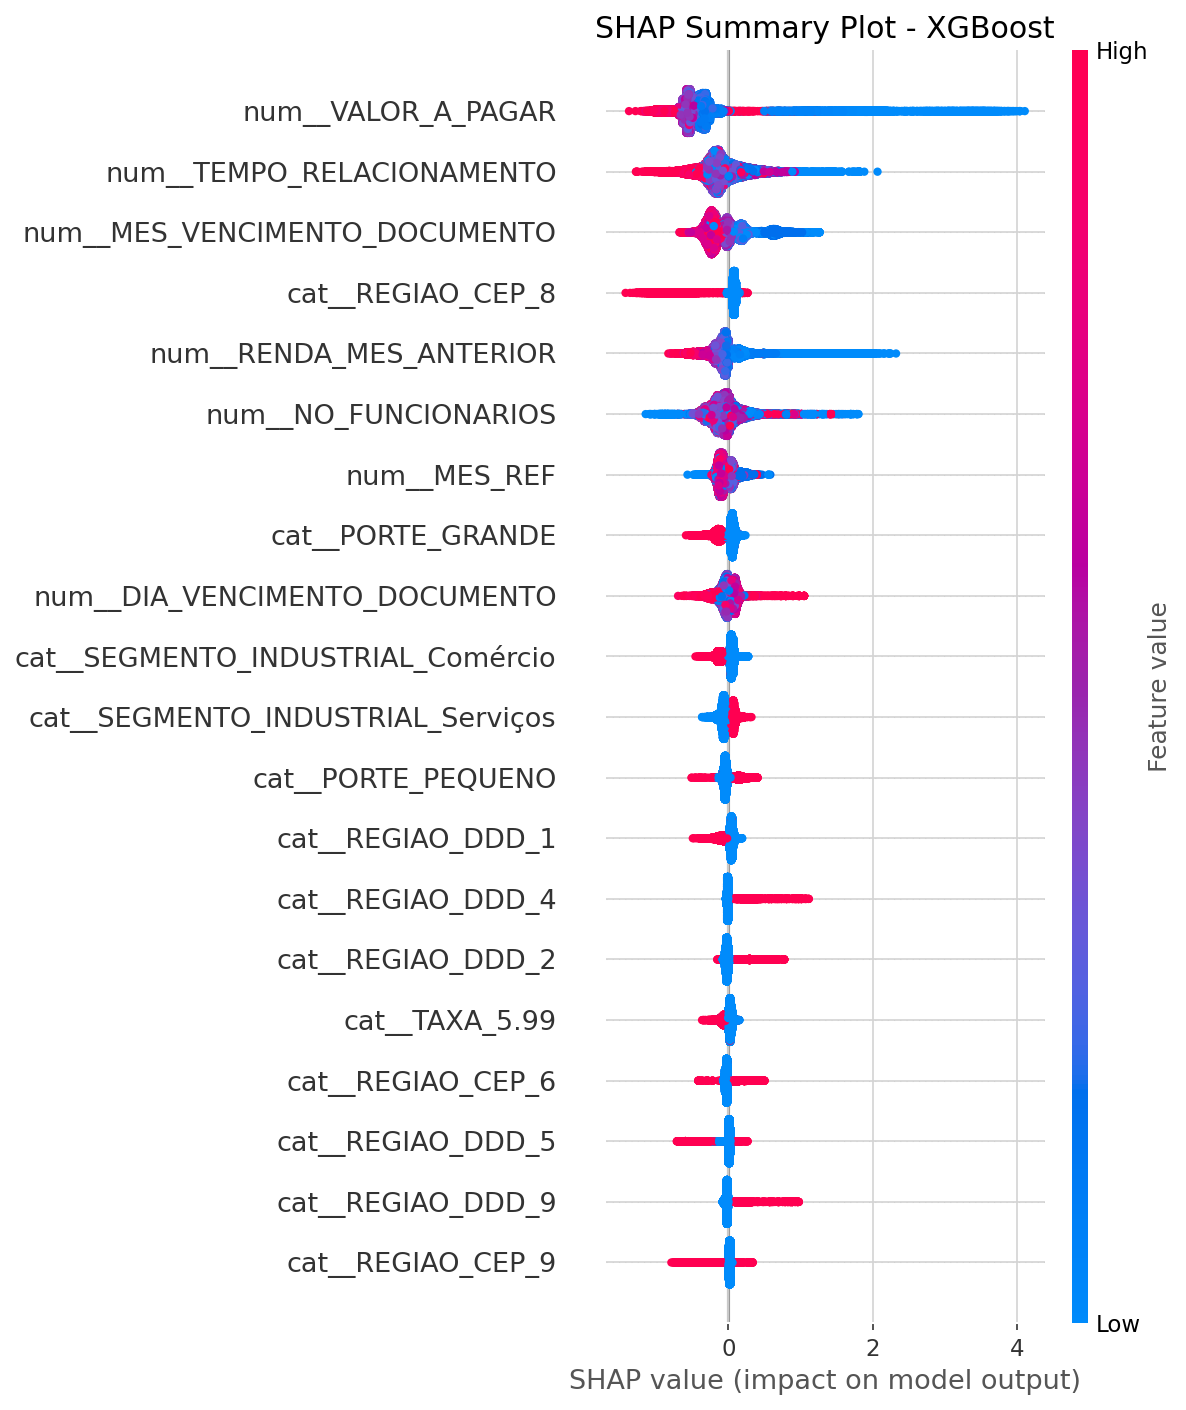

In [84]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.tight_layout()
plt.show()


#### **Interpretação do SHAP**

O SHAP Summary Plot mostra o impacto de cada variável nas previsões do XGBoost. As variáveis superiores são as mais relevantes; pontos rosados indicam valores altos e azulados valores baixos. A posição no eixo X reflete se a variável aumenta ou reduz a probabilidade de inadimplência.

**1. Variáveis financeiras e comportamentais lideram o risco**

* **`VALOR_A_PAGAR`** é a variável mais influente. Valores mais altos tendem a **reduzir o risco**, indicando que cobranças maiores estão associadas a clientes mais estáveis.
* **`TEMPO_RELACIONAMENTO`** mostra que clientes antigos têm menor inadimplência, enquanto novos concentram maior risco.

**2. Forte presença de sazonalidade e efeitos temporais**
Variáveis como `MES_VENCIMENTO_DOCUMENTO`, `MES_REF` e `DIA_VENCIMENTO_DOCUMENTO` revelam que o modelo captura padrões de época: alguns meses e dias estão associados a maior probabilidade de atraso, refletindo ciclos financeiros previsíveis.

**3. Perfil empresarial influencia o comportamento de pagamento**
Features relacionadas ao porte e segmento (`PORTE_GRANDE`, `PORTE_PEQUENO`, `SEGMENTO_Comércio`, `SEGMENTO_Serviços`) destacam que empresas maiores ou de setores mais estruturados apresentam risco menor.

**4. Fatores geográficos têm peso relevante**
Regiões de CEP e DDD, como `REGIAO_CEP_8`, aparecem entre as variáveis mais importantes, sugerindo **variação regional consistente no risco de inadimplência**.

**5. Coerência com análises anteriores**
O comportamento captado pelo XGBoost reforça tendências já observadas em modelos lineares:

* valor, tempo de relacionamento, fatores temporais e características cadastrais são determinantes no risco.


### **Feature Engineering: Comportamento e Saúde Financeira**
Para aumentar o poder preditivo sem incorrer em vazamento de dados (data leakage), vou criar variáveis que olham estritamente para o passado (safra anterior) ou para a estrutura financeira atual do cliente:

Variáveis de Histórico (Behavior):

`HIST_INAD_ANTERIOR`: Soma acumulada de vezes que o cliente atrasou > 5 dias em safras passadas. Captura o "hábito" de não pagar.

`HIST_FREQ_3M`: Média de inadimplência nos últimos 3 meses fechados. Indica deterioração recente.

`N_COBRANCAS`: Total de cobranças identificadas por usuário e safra.

Variáveis Financeiras (Capacity & Volatility):

`DTI_FATURAMENTO`: Razão entre o valor do boleto e a renda mensal estimada (Debt-to-Income). Indica se a dívida cabe no bolso da empresa.

`PAYMENT_SHOCK`: Razão entre o boleto atual e a média dos pagamentos recentes. Se alto (>1.5), indica um gasto atípico que pode gerar quebra de caixa.

`TICKET_POR_FUNC`: Valor da dívida dividido pelo número de funcionários. Proxy para o porte e robustez da empresa frente à dívida.

In [85]:
df_fe = feature_engineering(df)

new_features = [
    'HIST_INAD_ANTERIOR', 'HIST_FREQ_3M',
    'PAYMENT_SHOCK', 'DTI_FATURAMENTO',
    'TICKET_POR_FUNC', 'MEDIA_VALOR_3M',
    'N_COBRANCAS'
]

num_cols_fe = list(set(num_cols + new_features))

In [86]:
train_fe, test_fe = np.split(df_fe, [int(.80 * len(df))])

train_fe.head()

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,TARGET,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF,TEMPO_RELACIONAMENTO,DTI_FATURAMENTO,TICKET_POR_FUNC,MEDIA_VALOR_3M,PAYMENT_SHOCK,HIST_INAD_ANTERIOR,HIST_FREQ_3M,N_COBRANCAS
0,8784237149961904,2018-08-01,51393.0,5.99,0,0,Comércio,PEQUENO,1,2,NaN,NaN,11,9,18,1,8,2018,90,0.0,0.0,0.000000,0.000000,0.0,0.0,0
1,8784237149961904,2018-08-01,102686.1,5.99,0,0,Comércio,PEQUENO,1,2,NaN,NaN,10,9,18,1,8,2018,90,0.0,0.0,0.000000,0.000000,0.0,0.0,1
2,8784237149961904,2018-08-01,89552.8,5.99,0,0,Comércio,PEQUENO,1,2,NaN,NaN,11,9,20,1,8,2018,90,0.0,0.0,0.000000,0.000000,0.0,0.0,2
3,8784237149961904,2018-08-01,100616.1,5.99,0,0,Comércio,PEQUENO,1,2,NaN,NaN,4,9,18,1,8,2018,90,0.0,0.0,81210.633333,1.238952,0.0,0.0,3
4,8784237149961904,2018-08-01,94062.8,5.99,0,0,Comércio,PEQUENO,1,2,NaN,NaN,10,9,18,1,8,2018,90,0.0,0.0,97618.333333,0.963577,0.0,0.0,4


Pode-se separar novamente o conjunto de dados em treino e teste

In [87]:
X_train_fe = train_fe.drop(['TARGET', 'ID_CLIENTE', 'SAFRA_REF', 'ANO_REF'], axis=1)
y_train_fe = train_fe['TARGET']
X_test_fe = test_fe.drop(['TARGET', 'ID_CLIENTE', 'SAFRA_REF', 'ANO_REF'], axis=1)
y_test_fe = test_fe['TARGET']

In [88]:
X_train_fe.head()

,VALOR_A_PAGAR,TAXA,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,TEMPO_RELACIONAMENTO,DTI_FATURAMENTO,TICKET_POR_FUNC,MEDIA_VALOR_3M,PAYMENT_SHOCK,HIST_INAD_ANTERIOR,HIST_FREQ_3M,N_COBRANCAS
0,51393.0,5.99,0,Comércio,PEQUENO,1,2,NaN,NaN,11,9,18,1,8,90,0.0,0.0,0.000000,0.000000,0.0,0.0,0
1,102686.1,5.99,0,Comércio,PEQUENO,1,2,NaN,NaN,10,9,18,1,8,90,0.0,0.0,0.000000,0.000000,0.0,0.0,1
2,89552.8,5.99,0,Comércio,PEQUENO,1,2,NaN,NaN,11,9,20,1,8,90,0.0,0.0,0.000000,0.000000,0.0,0.0,2
3,100616.1,5.99,0,Comércio,PEQUENO,1,2,NaN,NaN,4,9,18,1,8,90,0.0,0.0,81210.633333,1.238952,0.0,0.0,3
4,94062.8,5.99,0,Comércio,PEQUENO,1,2,NaN,NaN,10,9,18,1,8,90,0.0,0.0,97618.333333,0.963577,0.0,0.0,4


In [89]:
num_preproc_fe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_preproc_fe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', num_preproc_fe, num_cols_fe),
        ('cat', cat_preproc_fe, cat_cols),
    ]
)

In [90]:
fe_log_reg = Pipeline(steps=[
    ('preprocess', preprocessor_fe),
    ('clf', logreg)
])

fe_log_reg.fit(X_train_fe, y_train_fe)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
y_preds_fe_log_reg = fe_log_reg.predict(X_test_fe)
y_probas_fe_log_reg = fe_log_reg.predict_proba(X_test_fe)[:, 1]

In [92]:
metrics_test = evaluate_global_metrics(y_test_fe, y_probas_fe_log_reg)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.827872
KS,0.543713
Gini,0.655744
Brier,0.053350


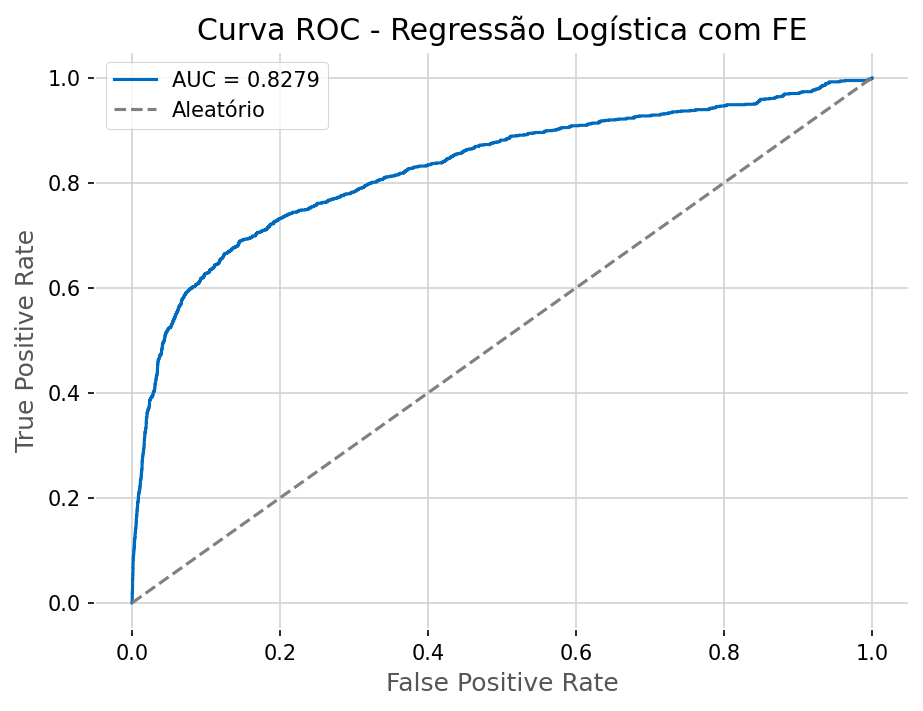

In [93]:
plot_roc_curve(y_test_fe, y_probas_fe_log_reg, title='Curva ROC - Regressão Logística com FE')

In [94]:
fe_log_reg.named_steps['preprocess'].get_feature_names_out()

array(['num__PAYMENT_SHOCK', 'num__DTI_FATURAMENTO',
       'num__HIST_INAD_ANTERIOR', 'num__RENDA_MES_ANTERIOR',
       'num__MEDIA_VALOR_3M', 'num__MES_REF',
       'num__DIA_VENCIMENTO_DOCUMENTO', 'num__DIA_REF',
       'num__TICKET_POR_FUNC', 'num__VALOR_A_PAGAR', 'num__HIST_FREQ_3M',
       'num__TEMPO_RELACIONAMENTO', 'num__MES_VENCIMENTO_DOCUMENTO',
       'num__NO_FUNCIONARIOS', 'num__N_COBRANCAS', 'cat__FLAG_PF_0',
       'cat__FLAG_PF_1', 'cat__TAXA_4.99', 'cat__TAXA_5.99',
       'cat__TAXA_6.99', 'cat__TAXA_8.99', 'cat__TAXA_11.99',
       'cat__SEGMENTO_INDUSTRIAL_Comércio',
       'cat__SEGMENTO_INDUSTRIAL_Indústria',
       'cat__SEGMENTO_INDUSTRIAL_Serviços', 'cat__PORTE_GRANDE',
       'cat__PORTE_MEDIO', 'cat__PORTE_PEQUENO', 'cat__REGIAO_DDD_0',
       'cat__REGIAO_DDD_1', 'cat__REGIAO_DDD_2', 'cat__REGIAO_DDD_3',
       'cat__REGIAO_DDD_4', 'cat__REGIAO_DDD_5', 'cat__REGIAO_DDD_6',
       'cat__REGIAO_DDD_7', 'cat__REGIAO_DDD_8', 'cat__REGIAO_DDD_9',
       'cat__RE

In [95]:
feature_names = fe_log_reg.named_steps['preprocess'].get_feature_names_out()
imp_log = get_logreg_importance(fe_log_reg, feature_names)
imp_log

,feature,coef,abs_coef
46,cat__REGIAO_CEP_8,-1.143930,1.143930
28,cat__REGIAO_DDD_0,0.887345,0.887345
0,num__PAYMENT_SHOCK,-0.758097,0.758097
10,num__HIST_FREQ_3M,0.744485,0.744485
15,cat__FLAG_PF_0,-0.722551,0.722551
32,cat__REGIAO_DDD_4,0.713064,0.713064
35,cat__REGIAO_DDD_7,-0.579792,0.579792
36,cat__REGIAO_DDD_8,-0.539372,0.539372
22,cat__SEGMENTO_INDUSTRIAL_Comércio,-0.538782,0.538782
25,cat__PORTE_GRANDE,-0.488837,0.488837


### **Comparação dos coefiecientes**

A nova regressão logística apresenta um perfil distinto da anterior, refletindo a inclusão de variáveis comportamentais e uma reorganização clara da importância relativa das features.

**1. Histórico comportamental**
Diferente dos coeficientes anteriores, dominada por efeitos geográficos e cadastrais, a criação das novas features traz:
- `PAYMENT_SHOCK` (negativo → reduz risco)
- `HIST_FREQ_3M` (positivo → aumenta risco)
- `HIST_INAD_ANTERIOR` (positivo)
Essas variáveis aparecem entre as mais importantes, indicando que **o modelo linear passou a capturar comportamento recente**.

**2. Geografia segue relevante, mas menos dominante**
Variáveis como `REGIAO_CEP_8`, `REGIAO_DDD_0`, `REGIAO_CEP_6`, `REGIAO_DDD_4` continuam com grande magnitude — porém não são mais o único bloco relevante.  
**A dependência de localização diminuiu**, indicando um modelo mais equilibrado.

**3. Perfil cadastral mantém efeito consistente**
- `PORTE_GRANDE` e `PORTE_MEDIO` continuam reduzindo risco.  
- `FLAG_PF_0` (empresas) permanece como redutor de inadimplência.  
Os padrões continuam coerentes com a regressão anterior.

**4. Variáveis financeiras e de porte ganham nuances**
- `VALOR_A_PAGAR` e `TICKET_POR_FUNC` aparecem com coeficientes negativos moderados.  
- Empresas com maior faturamento (proxy de renda/porte) tendem a inadimplir menos.

**5. Menor peso das variáveis temporais**
Diferente dos coeficientes anteriores, onde ano/mês tinham grande magnitude, aqui:
- `MES_VENCIMENTO_DOCUMENTO`, `MES_REF` e `DIA_VENCIMENTO_DOCUMENTO` aparecem **com magnitudes reduzidas**.  
O modelo ficou **menos sensível à sazonalidade** e mais dependente do comportamento histórico.

In [96]:
fe_xgb = Pipeline(steps=[
    ('preprocess', preprocessor_fe),
    ('clf', xgb)
])

fe_xgb.fit(X_train_fe, y_train_fe)
y_preds_fe_xgb = fe_xgb.predict(X_test_fe)
y_probas_fe_xgb = fe_xgb.predict_proba(X_test_fe)[:, 1]

In [97]:
metrics_test = evaluate_global_metrics(y_test_fe, y_probas_fe_xgb)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.895055
KS,0.639809
Gini,0.790110
Brier,0.047795


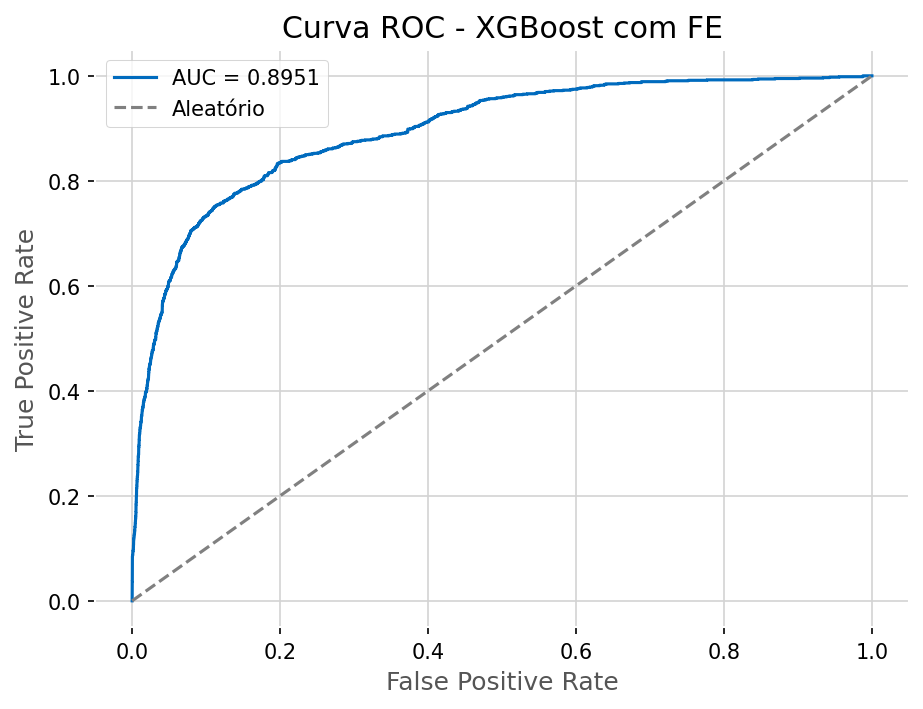

In [98]:
plot_roc_curve(y_test_fe, y_probas_fe_xgb, title='Curva ROC - XGBoost com FE')

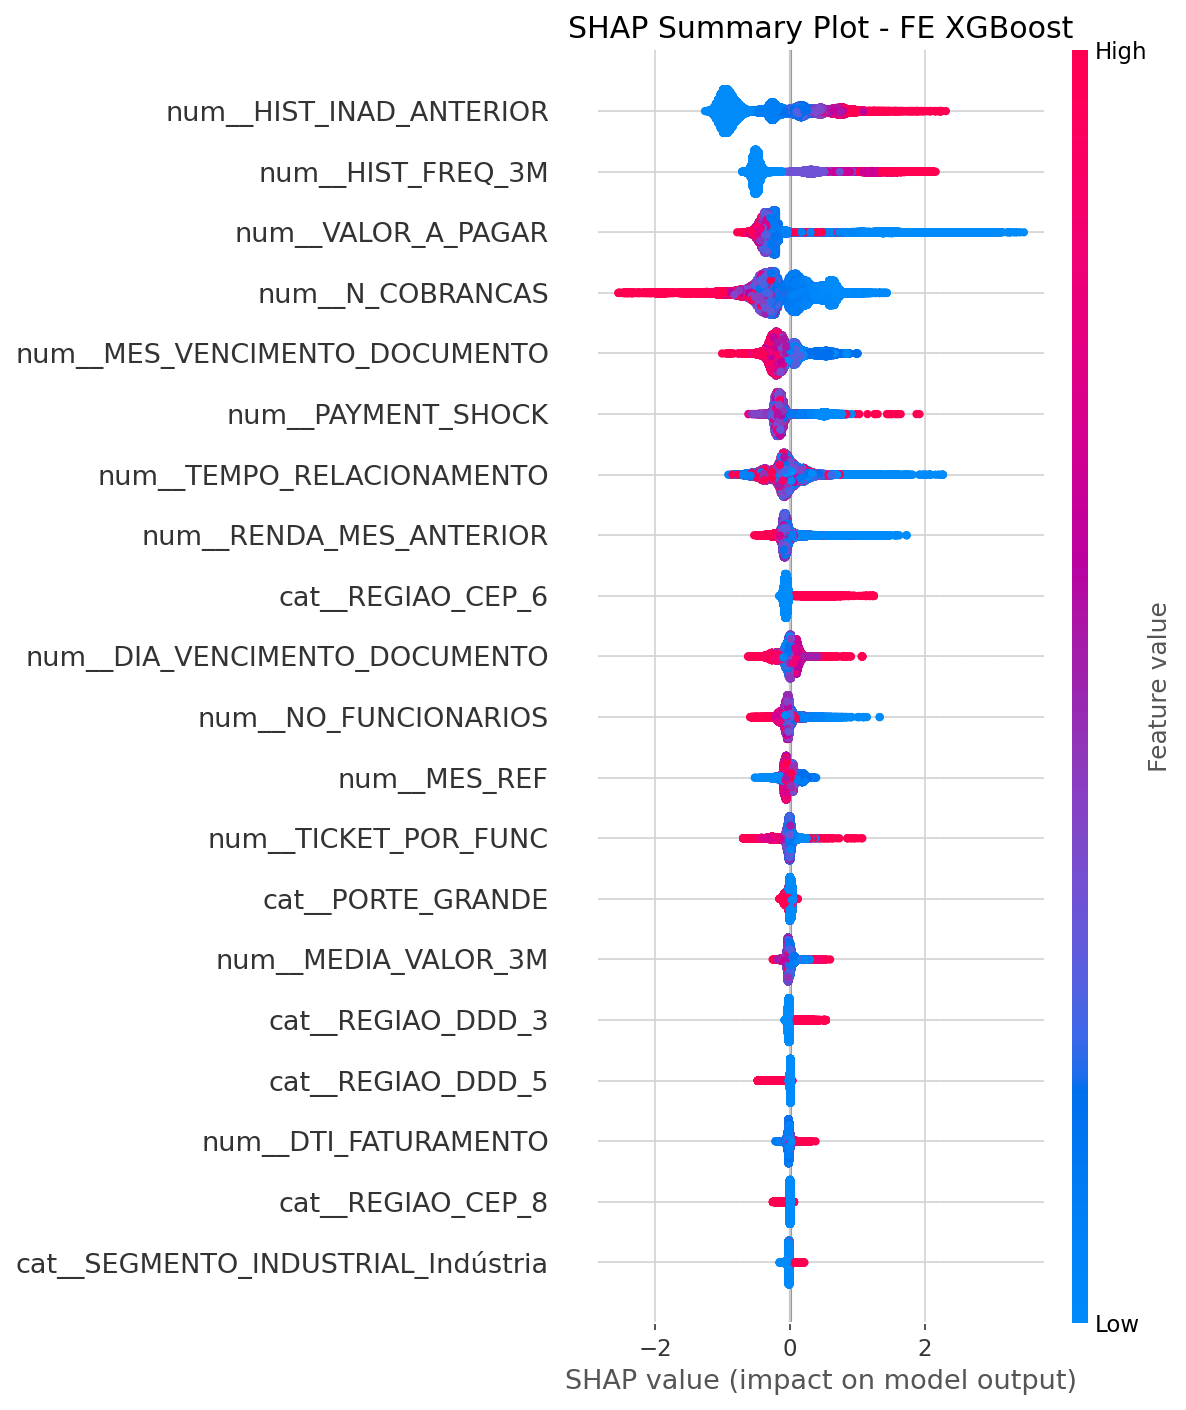

In [99]:
prep = fe_xgb.named_steps['preprocess']
xgb  = fe_xgb.named_steps['clf']

X_train_trans = prep.transform(X_train_fe)
feature_names = prep.get_feature_names_out()

feature_names
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_trans)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - FE XGBoost")
plt.tight_layout()
plt.show()


### **Comparação dos SHAPs**

O segundo SHAP mostra um modelo claramente **mais robusto** que o primeiro.

**1. Histórico passou a ser a 'categoria' mais importante**
- No novo modelo, variáveis como `HIST_INAD_ANTERIOR`, `HIST_FREQ_3M`, `N_COBRANCAS` e `PAYMENT_SHOCK` aparecem no topo. O modelo passa a usar **comportamento passado**, muito mais preditivo que valor, porte ou região.

**2. Menor dependência de sazonalidade**
- Variáveis de mês e dia continuam relevantes, mas **perdem peso** porque o modelo agora tem boas features comportamentais.

**3. Cadastral e geografia**
- Porte, segmento e regiões ainda ajudam, porém deixam de dominar o risco.

**4. `VALOR_A_PAGAR` perde um pouco de espaço**
- Antes era a principal variável, agora é apenas mais uma entre outras importantes, indicando melhor equilíbrio das fontes de informação.


### **Comparação entre os modelos**

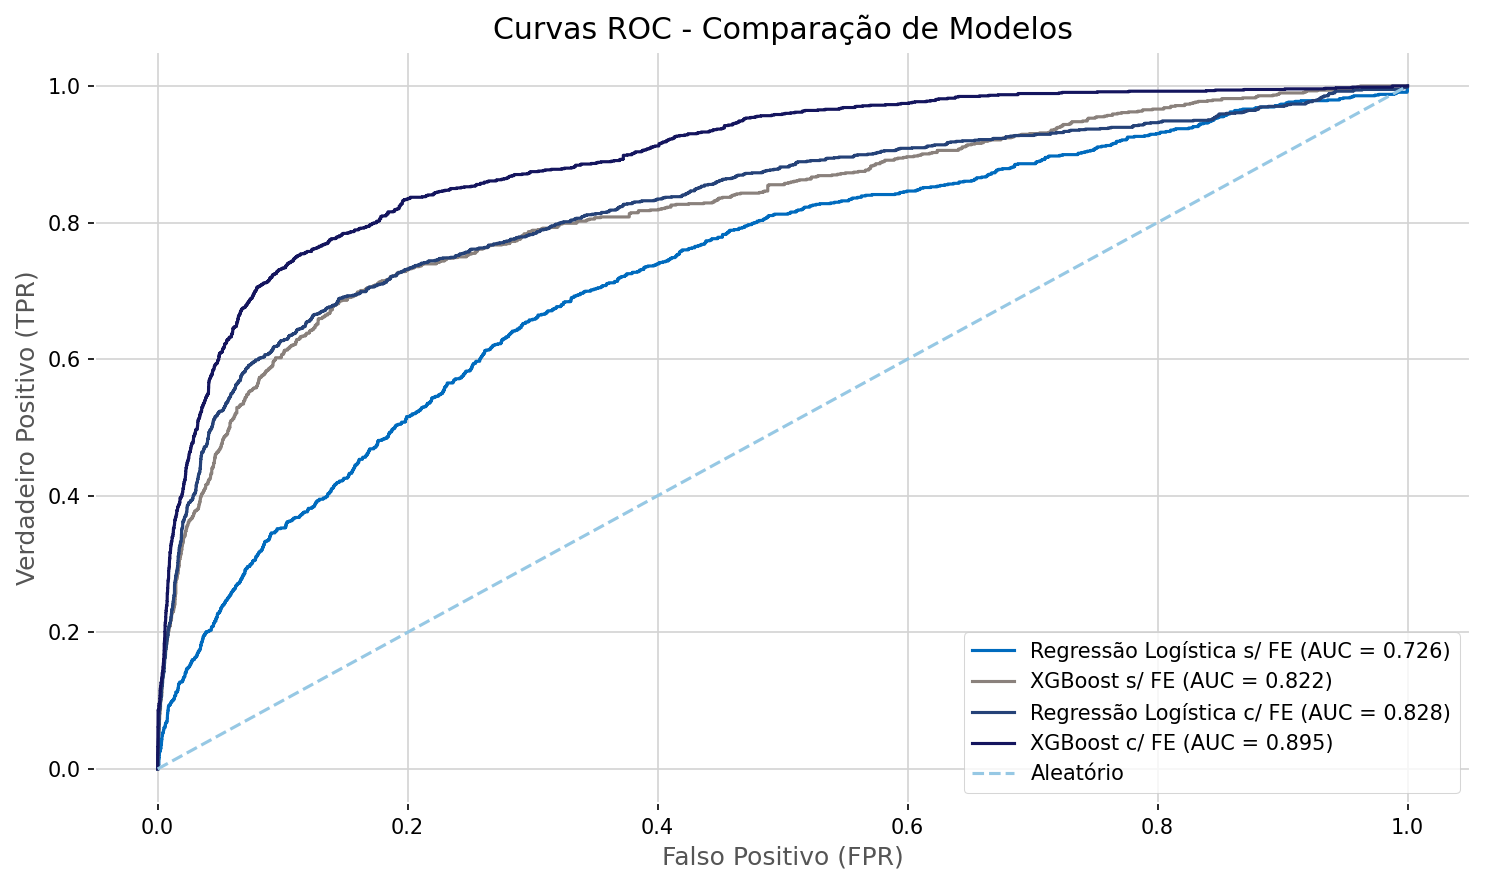

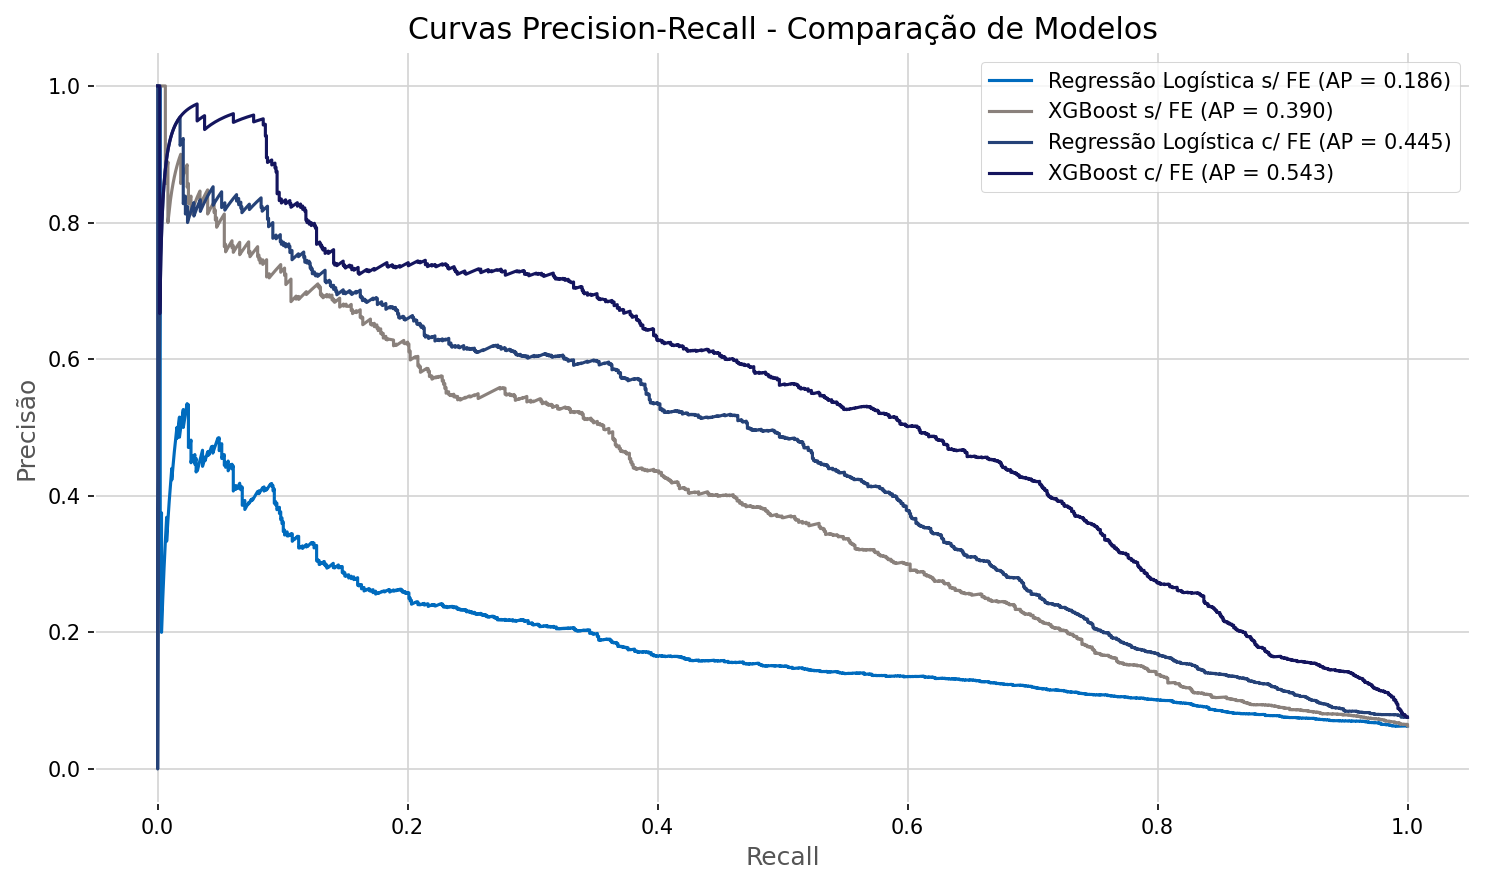

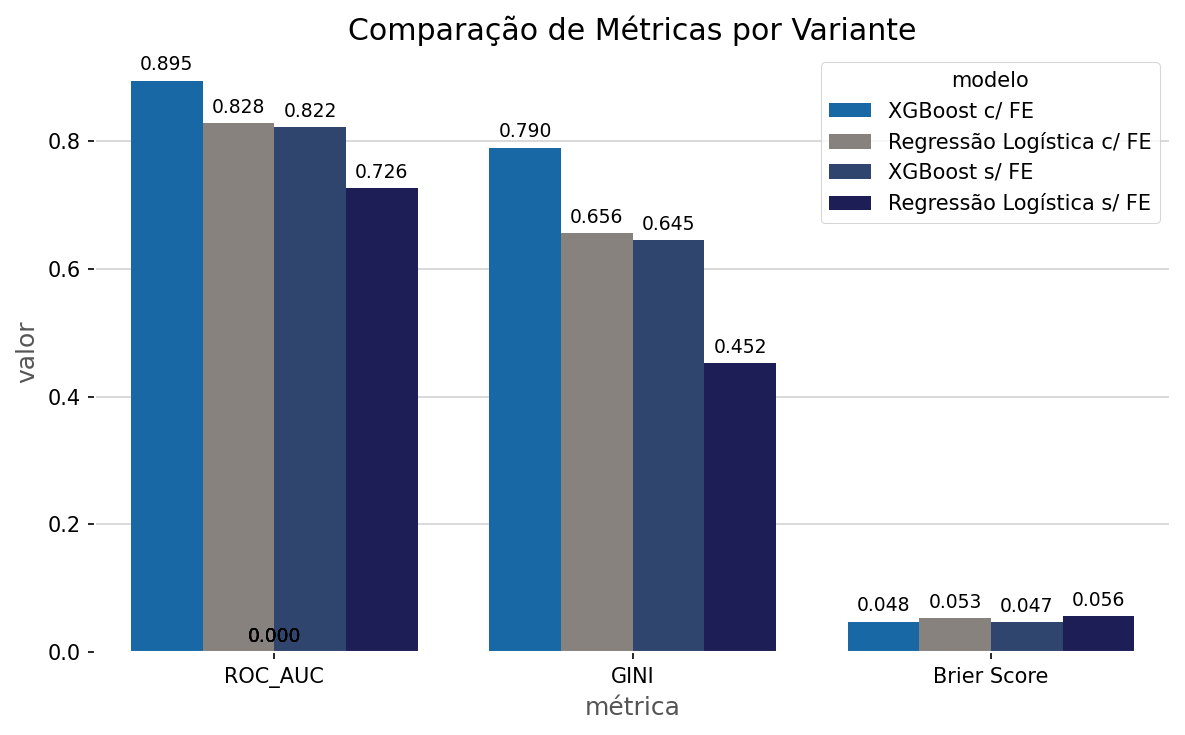

,modelo,ROC_AUC,GINI,Average Precision,Brier Score
3,XGBoost c/ FE,0.895055,0.790110,0.542620,0.047795
2,Regressão Logística c/ FE,0.827872,0.655744,0.445320,0.053350
1,XGBoost s/ FE,0.822406,0.644812,0.389615,0.047310
0,Regressão Logística s/ FE,0.726061,0.452123,0.185537,0.055746


In [100]:
experiments = {
    "Regressão Logística s/ FE": {
        "model": baseline_log_reg,
        "X_train": X_train,
        "y_train": y_train,
        "X_valid": X_test,
        "y_valid": y_test,
    },
    "XGBoost s/ FE": {
        "model": baseline_xgb,
        "X_train": X_train,
        "y_train": y_train,
        "X_valid": X_test,
        "y_valid": y_test,
    },
    "Regressão Logística c/ FE": {
        "model": fe_log_reg,
        "X_train": X_train_fe,
        "y_train": y_train_fe,
        "X_valid": X_test_fe,
        "y_valid": y_test_fe,
    },
    "XGBoost c/ FE": {
        "model": fe_xgb,
        "X_train": X_train_fe,
        "y_train": y_train_fe,
        "X_valid": X_test_fe,
        "y_valid": y_test_fe,
    },
}

results_df, y_scores_dict = compare_model_variants(
    experiments,
    plot_roc=True,
    plot_pr=True,
    plot_bar=True,
    title_roc="Curvas ROC - Comparação de Modelos"
)

display(results_df)


### **Conclusão e Escolha do Modelo**

Após a avaliação em Out-of-Time (OOT), o XGBoost com Feature Engineering demonstrou superioridade clara frente à Regressão Logística com e sem o processo de seleção e ao XGBoost sem este processo.:

- **Discriminação (AUC & KS)**: O XGBoost c/ FE obteve maior capacidade de separar bons de maus pagadores, capturando relações não lineares (ex: o risco de um `PAYMENT_SHOCK` alto pode ser mitigado se o `TEMPO_RELACIONAMENTO` for longo).
- **Calibração (Brier Score)**: O modelo apresentou probabilidades consistentes com a taxa real de inadimplência.

Decisão: Seguiremos com o XGBoost c/ FE para a submissão final, pois ele maximiza a detecção de inadimplentes mantendo uma taxa de falsos positivos controlada.

### **Modelo salvo**

In [101]:
model_filename = '../credit_risk_pipeline.pkl'
joblib.dump(fe_xgb, model_filename)
print(f"Pipeline salvo com sucesso em: {model_filename}")

Pipeline salvo com sucesso em: ../credit_risk_pipeline.pkl
